<a href="https://colab.research.google.com/github/MercuryAtom31/Business-Physics-AI-Lab/blob/main/Experiment_3_ForecastingBusinessTrendsUsingFacebookProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Experiment 3: Forecasting Business Trends Using Facebook Prophet

#What is Facebook Prophet?

Facebook Prophet is a tool developed by Facebook that helps you predict future trends based on past data. Think of it like a smart weather forecaster, but instead of predicting rain or sunshine, it predicts things like sales, website traffic, or demand for a product.

### Business Applications

- **Sales Forecasting:**  
  Businesses use Prophet to predict future sales based on historical sales data. This helps them manage inventory, schedule staffing, and plan marketing campaigns more effectively.

- **Demand Forecasting:**  
  Retailers or manufacturers use Prophet to estimate how many units of a product will be needed in the future. This ensures they can meet customer demand without overproducing or running out of stock.

- **Website Traffic Predictions:**  
  Digital marketers can use Prophet to forecast website visits or app usage. This insight allows them to plan for higher traffic periods and optimize server capacity.

- **Financial Planning:**  
  Companies can predict revenue, expenses, or cash flow trends over time. This helps in making strategic decisions such as budgeting, investments, and resource allocation.

### Why It's Popular

- **User-Friendly:**  
  Prophet is designed to work well even if your data isn’t perfect. It’s robust to missing data and shifts in trends, which makes it very accessible to users without deep expertise in time series analysis.

- **Customizable:**  
  You can easily adjust the model to account for unusual events (like holidays or special promotions) by adding those as extra factors, making the forecasts more accurate.

- **Quick Insights:**  
  With simple commands and clear visualizations, Prophet gives businesses a quick way to understand trends and plan for the future.

In summary, Facebook Prophet is like a forecasting assistant that helps businesses and individuals make informed decisions by predicting future trends based on historical data.


####Step 1: Install Dependencies

In [1]:
pip install prophet pandas matplotlib

###Step 2: Import Libraries and Load the Data

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load your dataset
df = pd.read_csv("sales_data_sample.csv", encoding="cp949")

###Step 3: Inspect and Clean the Data

####1. Check the columns to see what’s available

In [33]:
print(df.columns)
print(df.head())

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         


- **Convert Date Strings:**  
  The first line converts the values in the `ORDERDATE` column from strings into datetime objects. Any values that cannot be converted are set to `NaT` (Not a Time) because of `errors='coerce'`.

- **Remove Invalid Dates:**  
  The second line removes any rows from the DataFrame where the `ORDERDATE` conversion failed (i.e., where the value is `NaT`).


In [34]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')
# Drop any rows where conversion failed (if any)
df = df.dropna(subset=['ORDERDATE'])

- **Convert Sales to Numeric:**  
  The first line transforms the values in the `SALES` column into numeric (number) format. If any value can't be converted, it will be set to `NaN` due to `errors='coerce'`.

- **Remove Invalid Sales Data:**  
  The second line removes any rows from the DataFrame where the `SALES` value is `NaN`, ensuring that all remaining rows have valid numeric sales data.

In [35]:
df['SALES'] = pd.to_numeric(df['SALES'], errors='coerce')
df = df.dropna(subset=['SALES'])


- **Group by Date:**  
  This line groups the data by the `ORDERDATE` column.
  Often, multiple orders occur on the same day. It’s a good idea to aggregate sales by day

- **Aggregate Sales:**  
  For each date, it calculates the total sales by summing up all the `SALES` values.

- **Resulting DataFrame:**  
  The result is a new DataFrame (`daily_sales`) where each row represents a unique date and its corresponding summed sales.


In [36]:
daily_sales = df.groupby('ORDERDATE', as_index=False)['SALES'].sum()

###Now we have a DataFrame (daily_sales) with the total sales per day.

In [37]:
print(daily_sales.head())

   ORDERDATE     SALES
0 2003-01-06  12133.25
1 2003-01-09  11432.34
2 2003-01-10   6864.05
3 2003-01-29  54702.00
4 2003-01-31  44621.96


- **Rename Columns:**  
  The code renames `ORDERDATE` to `ds` and `SALES` to `y` because Prophet, the forecasting tool, requires the input data to have these specific column names:
  - `ds` represents the date or timestamp.
  - `y` represents the value you want to forecast (in this case, sales).

- **In-Place Modification and Preview:**  
  `inplace=True` updates the existing DataFrame directly, and `print(daily_sales.head())` displays the first few rows to confirm the changes.

In [38]:
daily_sales.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)
# Inspect the result
print(daily_sales.head())

          ds         y
0 2003-01-06  12133.25
1 2003-01-09  11432.34
2 2003-01-10   6864.05
3 2003-01-29  54702.00
4 2003-01-31  44621.96


- **Initialize the Prophet Model:**  
  `model = Prophet()` creates a new instance of the Prophet forecasting model with default settings.

- **Fit the Model:**  
  `model.fit(daily_sales)` trains the Prophet model using the aggregated daily sales data. The data is expected to have columns named `ds` (date) and `y` (sales).

- **Create Future Dataframe:**  
  `future = model.make_future_dataframe(periods=30)` generates a DataFrame that includes both the historical dates and an additional 30 days into the future for which the model will forecast sales.

- **Predict Future Sales:**  
  `forecast = model.predict(future)` uses the trained model to predict future sales for each date in the `future` DataFrame.  
  - `yhat` represents the predicted sales values.  
  - `yhat_lower` and `yhat_upper` provide the lower and upper bounds of the prediction interval, giving a measure of uncertainty.

- **Display Forecast Results:**  
  `print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())` prints the last few rows of the forecast DataFrame, showing the predictions and their uncertainty intervals for the most recent dates.


In [39]:
# Initialize the Prophet Model
model = Prophet()
# Fit the model using the daily aggregated sales data
model.fit(daily_sales)

# how far ahead you want to forecast (e.g., 90 days)
future = model.make_future_dataframe(periods=30)

# Predict the Future Sales, Generate the forecast:
forecast = model.predict(future)
# Display the last few forecast rows
# yhat is the predicted sales.
# yhat_lower and yhat_upper provide uncertainty intervals.
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/kxwuu_zt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/28nfgjdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67625', 'data', 'file=/tmp/tmp9a4o68f2/kxwuu_zt.json', 'init=/tmp/tmp9a4o68f2/28nfgjdz.json', 'output', 'file=/tmp/tmp9a4o68f2/prophet_modelf_gser_o/prophet_model-20250311183258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds          yhat   yhat_lower    yhat_upper
277 2005-06-26  37991.924021  9816.147917  67051.562414
278 2005-06-27  25772.032428 -1877.243592  53546.361049
279 2005-06-28  33849.345776  6468.582432  62950.125255
280 2005-06-29  30322.275852  1009.711583  58288.489593
281 2005-06-30  34783.406936  4923.340834  62813.131376


## Visualize the Forecast
- **Forecast Plot:**  
  `fig1 = model.plot(forecast)` generates a visual representation of both the historical data and the future predictions.  
  - **Black Dots (Historical Data):** Each dot corresponds to a past date’s actual sales figure.  
  - **Blue Line (Forecast):** This line shows the model’s predicted sales (`yhat`) across time, including future dates.  
  - **Light Blue Shaded Area (Uncertainty Interval):** The shaded region around the blue line indicates the model’s confidence range, bounded by `yhat_lower` and `yhat_upper`. A wider band suggests greater uncertainty in the prediction.


**Explanation of the Forecast Plot**

1. **Black Dots (Historical Sales):**  
   These points show your actual past sales data for each date. They give you a sense of where your real sales have been.

2. **Blue Line (Predicted Sales):**  
   This is Prophet’s best guess of how sales evolve over time, based on the historical data. As you move further to the right (future dates), it shows the model’s forecasted sales.

3. **Light Blue Shaded Area (Uncertainty Interval):**  
   The shaded region around the blue line indicates how confident the model is in its predictions. A narrower band means the model is more certain about that forecast; a wider band means there’s more uncertainty in the estimate.

Overall, the plot shows where your sales have been (the black dots) and where Prophet thinks they’re heading (the blue line), with a built-in margin of error (the shaded area). This helps you quickly see if the model is capturing the general trend and seasonality in your sales data, and how much confidence you can have in future predictions.


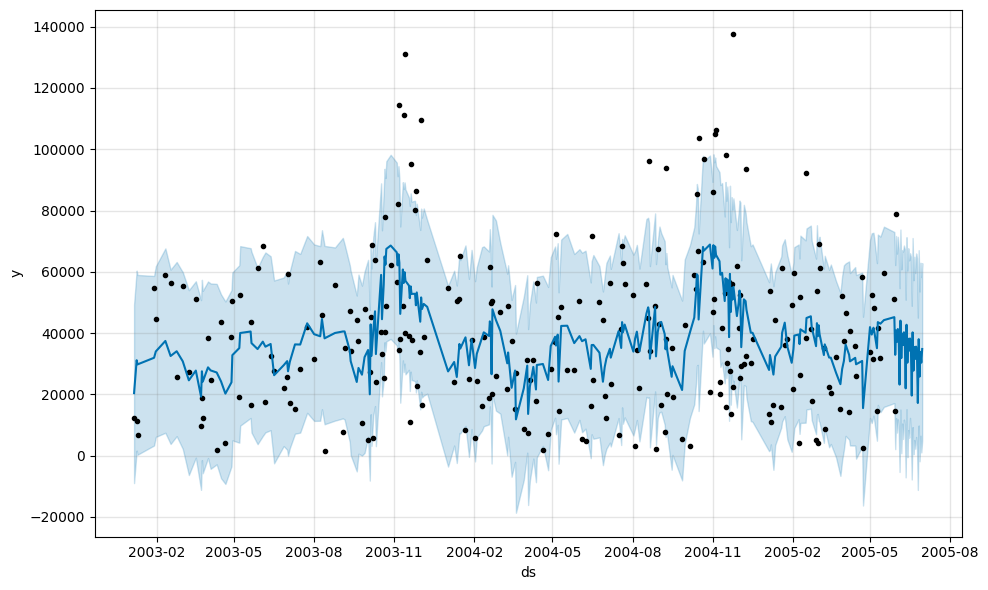

In [40]:
fig1 = model.plot(forecast)
plt.show()

Create a Future DataFrame and Generate Forecast
**Plain-English Explanation**

1. **Extend the Forecast (90 Days):**  
   - `future = model.make_future_dataframe(periods=90)` creates new rows in the data for 90 days beyond your last historical date. This tells Prophet how far into the future to predict.

2. **Generate Predictions:**  
   - `forecast = model.predict(future)` uses the trained model to estimate sales for each date in `future`.  
   - The resulting `forecast` DataFrame includes columns like:
     - `ds` (date)
     - `yhat` (predicted sales)
     - `yhat_lower` and `yhat_upper` (prediction intervals)

3. **Preview Forecast Results:**  
   - `print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())` shows the last few rows of the forecast, so you can see the model’s predictions near the end of the forecast window.

4. **Visualize the Forecast:**  
   - `fig1 = model.plot(forecast)` produces a plot where:
     - Black dots represent historical data.
     - The blue line shows the model’s predicted sales.
     - The light blue shaded region indicates the uncertainty around the forecast.
   - `plt.show()` displays this forecast plot.

5. **View Forecast Components:**  
   - `fig2 = model.plot_components(forecast)` breaks down the forecast into its underlying components, such as:
     - Overall trend
     - Weekly seasonality (if enabled)
     - Yearly seasonality (if enabled)
     - Other custom seasonalities or regressors (if added)
   - `plt.show()` displays these separate component plots, helping you understand what patterns Prophet found in your data.


            ds          yhat    yhat_lower    yhat_upper
337 2005-08-25  54102.242168  27789.549668  81769.162754
338 2005-08-26  51775.273780  22662.215427  81111.865365
339 2005-08-27  32669.524987   5897.211052  63797.787130
340 2005-08-28  52793.888102  23258.378332  78934.577070
341 2005-08-29  40220.865413  11332.041820  69359.385650


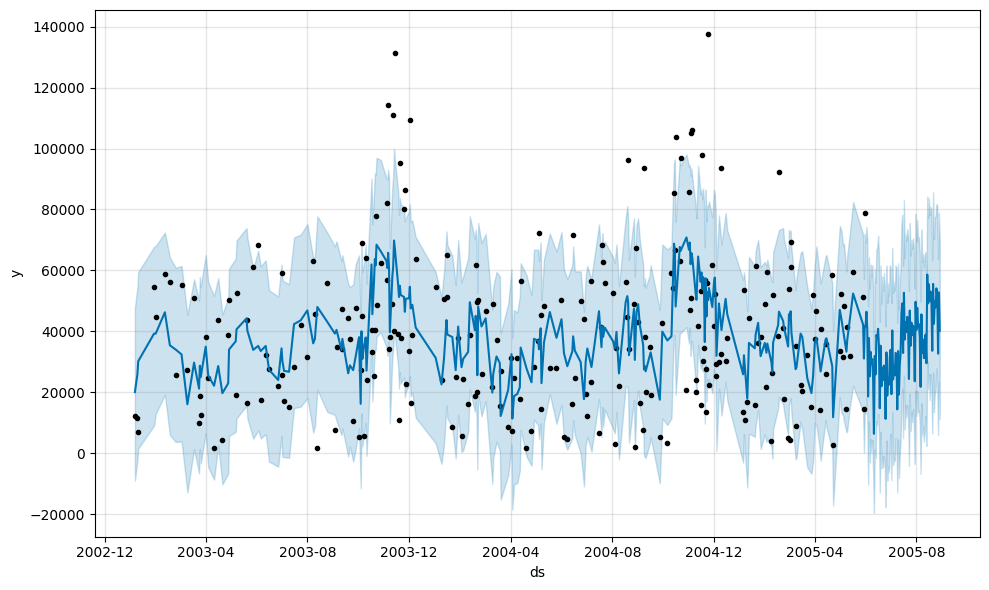

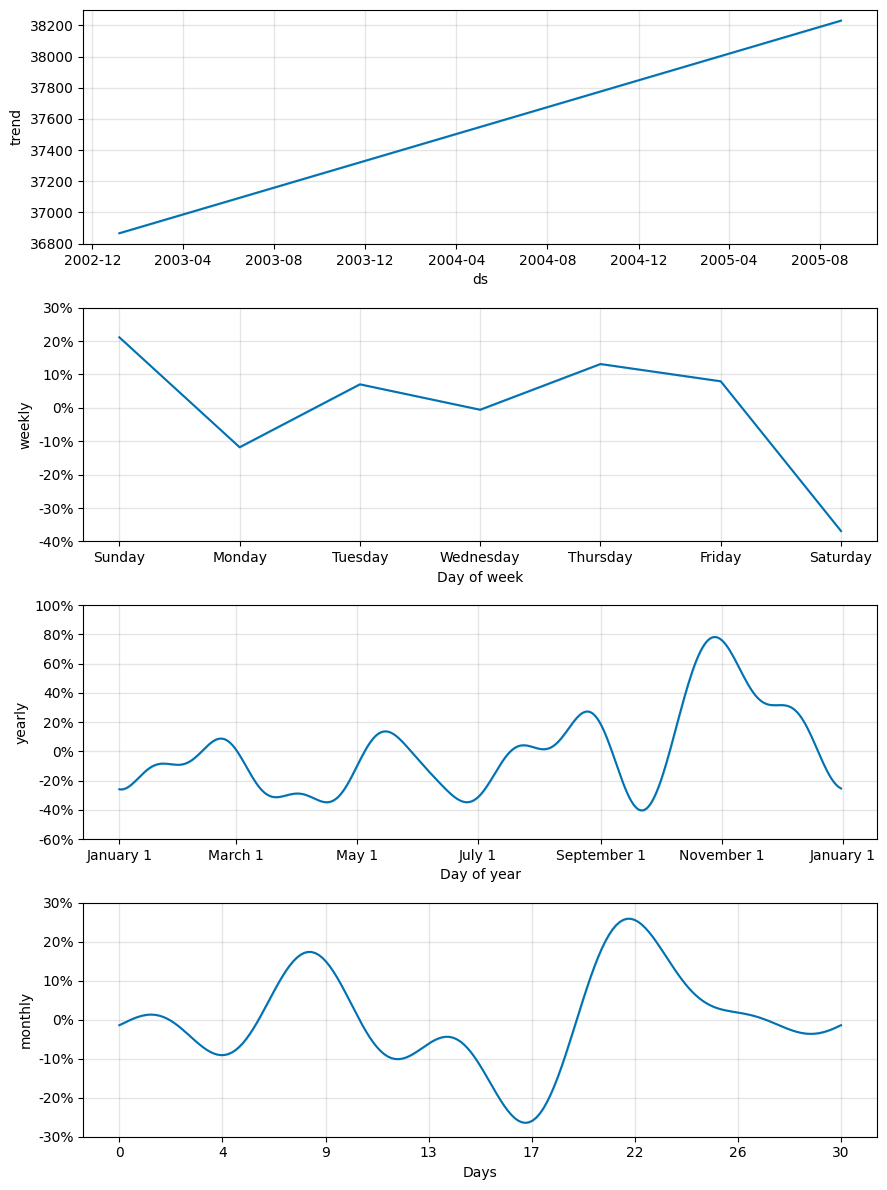

In [24]:
# Step 1: Create a future dataframe for 90 additional days
future = model.make_future_dataframe(periods=90)

# Step 2: Generate the forecast
forecast = model.predict(future)

# Step 3: Inspect the forecast (last few rows)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

import matplotlib.pyplot as plt

# Plot the forecast
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


#Simulating Seasonal Spikes

**Explanation of the Plot**

1. **Time Range (X-axis):**  
   The horizontal axis shows dates from January 2024 through early January 2025.

2. **Sales Values (Y-axis):**  
   The vertical axis displays the simulated sales figures. Notice how they gradually increase over time (the underlying linear trend) but also oscillate up and down.

3. **Seasonal Spikes:**  
   The wavelike pattern you see (peaks and troughs) represents recurring sales spikes every 90 days. This mimics periodic events such as holiday seasons or promotions.

4. **Random Fluctuations:**  
   The slight variations in height from one day to the next (rather than a perfectly smooth sine wave) come from adding random noise. This makes the data look more realistic—sales rarely follow a perfectly smooth pattern in real life.

Overall, this plot shows a synthetic dataset where sales gradually increase over the year but also experience regular surges, just like a business might see around special events or holiday periods.


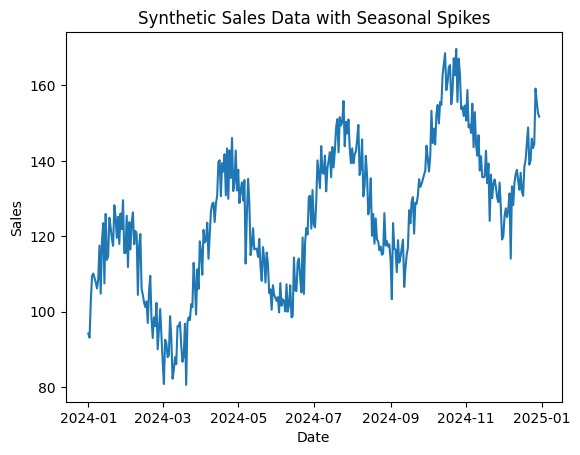

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Generate dates for one year
start_date = datetime(2024, 1, 1)
num_days = 365
dates = [start_date + timedelta(days=i) for i in range(num_days)]

# Create a basic trend (e.g., slowly increasing sales)
base_sales = np.linspace(100, 150, num_days)

# Simulate a seasonal spike every 90 days (e.g., holiday promotion)
seasonal_effect = 20 * np.sin(2 * np.pi * np.arange(num_days) / 90)

# Combine base trend with seasonal spike and add some random noise
sales = base_sales + seasonal_effect + np.random.normal(0, 5, num_days)

# Create DataFrame
df_seasonal = pd.DataFrame({'ds': dates, 'y': sales})

# Visualize the synthetic data
plt.plot(df_seasonal['ds'], df_seasonal['y'])
plt.title("Synthetic Sales Data with Seasonal Spikes")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Simulating Economic Downturns


**Explanation of the Plot**

1. **Overall Trend:**  
   The line mostly shows a rising trend over time, indicating that sales gradually increase as the year progresses.

2. **Downturn Period:**  
   Between approximately May and July (days 150 to 200 in the synthetic timeline), the sales values drop noticeably, reflecting a temporary economic slump or crisis.

3. **Recovery:**  
   After the downturn, sales begin to climb again, eventually returning to—and even surpassing—the level of growth from before the slump.

4. **Random Fluctuations:**  
   The minor ups and downs throughout the chart come from added noise, making the data appear more realistic. Real-world sales rarely follow a perfectly smooth curve.

Overall, this synthetic scenario illustrates how a sudden drop in sales might look when graphed, followed by a rebound as conditions improve.


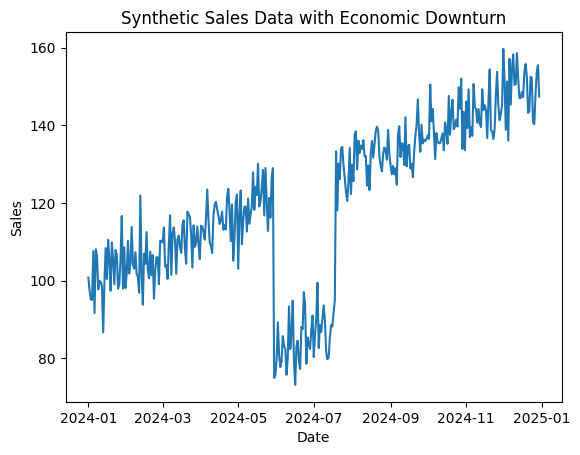

In [26]:
# Copy the base sales trend and add downturn effect
sales_downturn = base_sales.copy()

# Define a downturn period (e.g., from day 150 to day 200)
downturn_start, downturn_end = 150, 200
sales_downturn[downturn_start:downturn_end] *= 0.7  # reduce sales by 30%

# Add some noise
sales_downturn += np.random.normal(0, 5, num_days)

# Create DataFrame
df_downturn = pd.DataFrame({'ds': dates, 'y': sales_downturn})

# Visualize the synthetic data with downturn
plt.plot(df_downturn['ds'], df_downturn['y'])
plt.title("Synthetic Sales Data with Economic Downturn")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Simulating Promotional Periods

**Explanation of the Plot**

1. **Overall Trend:**  
   The line gradually moves upward over the year, suggesting that sales are increasing over time.

2. **Promotional Spike:**  
   Around the middle of the timeline (day 250 to day 260 in the synthetic dataset), there is a noticeable jump in sales. This short-term boost reflects the effect of a promotional period, like a special sale or marketing campaign.

3. **Return to Normal:**  
   After the promotion ends, sales dip back toward their typical growth path, indicating the end of the campaign's direct impact.

4. **Day-to-Day Variability:**  
   The slight fluctuations around the general trend come from added noise, making the data look more realistic by simulating everyday ups and downs in consumer behavior.

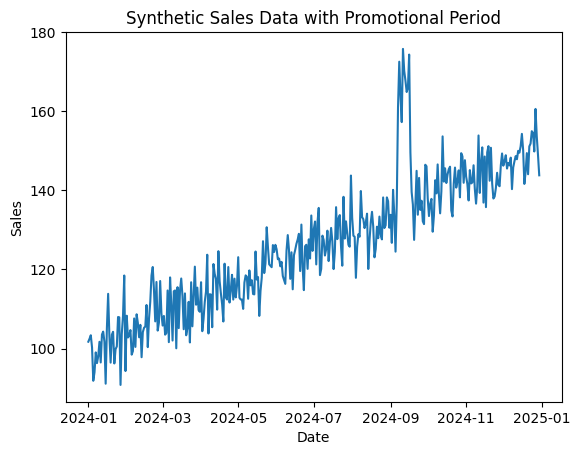

In [27]:
# Copy the base sales trend and add a promotional effect
sales_promotion = base_sales.copy()

# Define a promotional period (e.g., day 250 to day 260)
promo_start, promo_end = 250, 260
sales_promotion[promo_start:promo_end] += 30  # add a temporary bump

# Add some noise
sales_promotion += np.random.normal(0, 5, num_days)

# Create DataFrame
df_promo = pd.DataFrame({'ds': dates, 'y': sales_promotion})

# Visualize the synthetic data with a promotion
plt.plot(df_promo['ds'], df_promo['y'])
plt.title("Synthetic Sales Data with Promotional Period")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

###Testing Your Forecast Model
Once you have these different synthetic datasets, you can:

Fit a Prophet Model to Each Dataset

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/iag7uca2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/zsdbjv8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87332', 'data', 'file=/tmp/tmp9a4o68f2/iag7uca2.json', 'init=/tmp/tmp9a4o68f2/zsdbjv8c.json', 'output', 'file=/tmp/tmp9a4o68f2/prophet_modelcbxgm4mf/prophet_model-20250311180759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


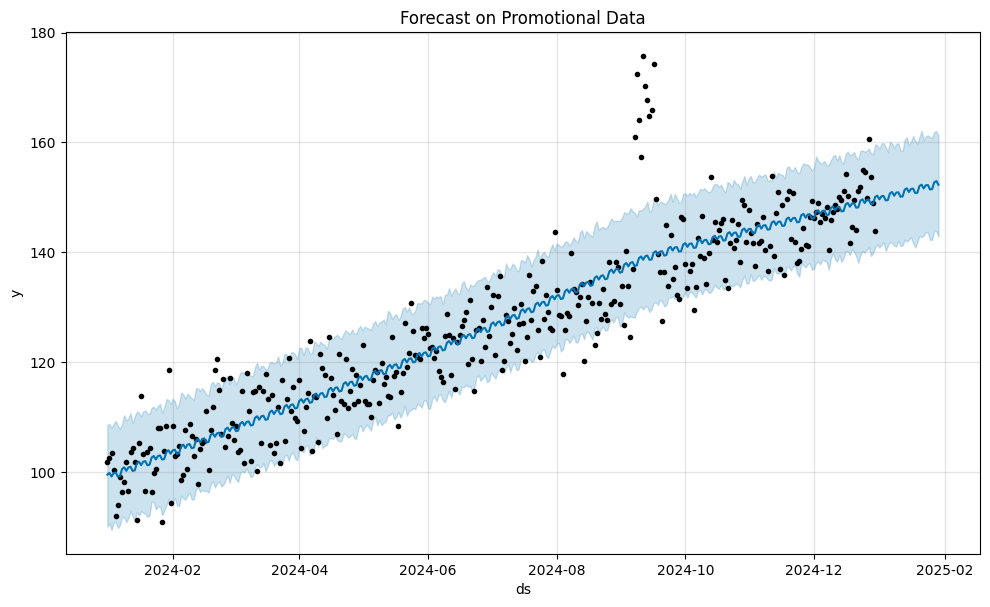

In [28]:
from prophet import Prophet

# Example for the promotional data
model_promo = Prophet()
model_promo.fit(df_promo)
future = model_promo.make_future_dataframe(periods=30)
forecast_promo = model_promo.predict(future)
model_promo.plot(forecast_promo)
plt.title("Forecast on Promotional Data")
plt.show()

##Synthetic Sales Data with Seasonal Spikes
Plot Description: You’re seeing a sine‐like wave superimposed on a general trend, indicating periodic surges in sales (e.g., a holiday season every few months).
What This Tells You:
Your data now has regular up‐and‐down patterns that mimic real‐world seasonality (like weekends, monthly cycles, or quarterly promotions).
It’s a great way to see if Prophet can capture and forecast those repeating peaks and troughs accurately.

#Seasonal Spikes Scenario
This example simulates a sine‐wave effect (seasonal spikes) added to a basic upward trend

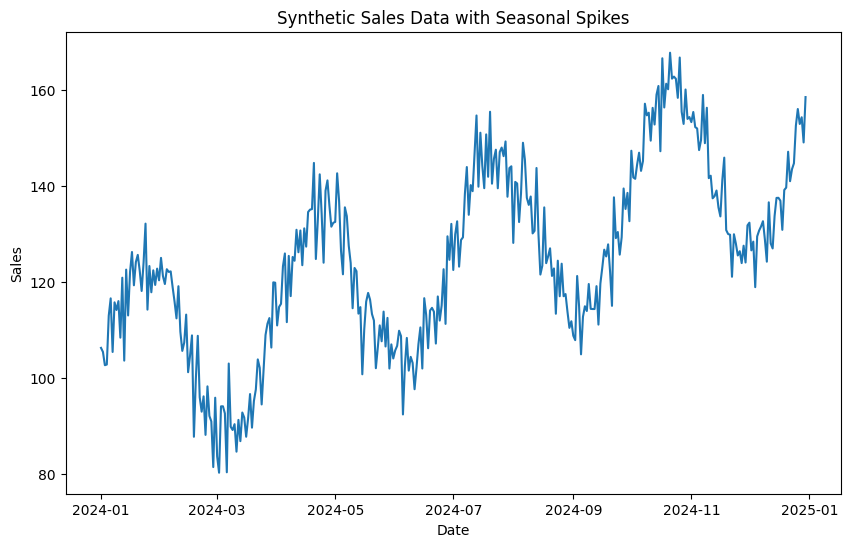

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/98_se_b2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/5vq1zenm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33727', 'data', 'file=/tmp/tmp9a4o68f2/98_se_b2.json', 'init=/tmp/tmp9a4o68f2/5vq1zenm.json', 'output', 'file=/tmp/tmp9a4o68f2/prophet_modelvjf039rq/prophet_model-20250311181751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


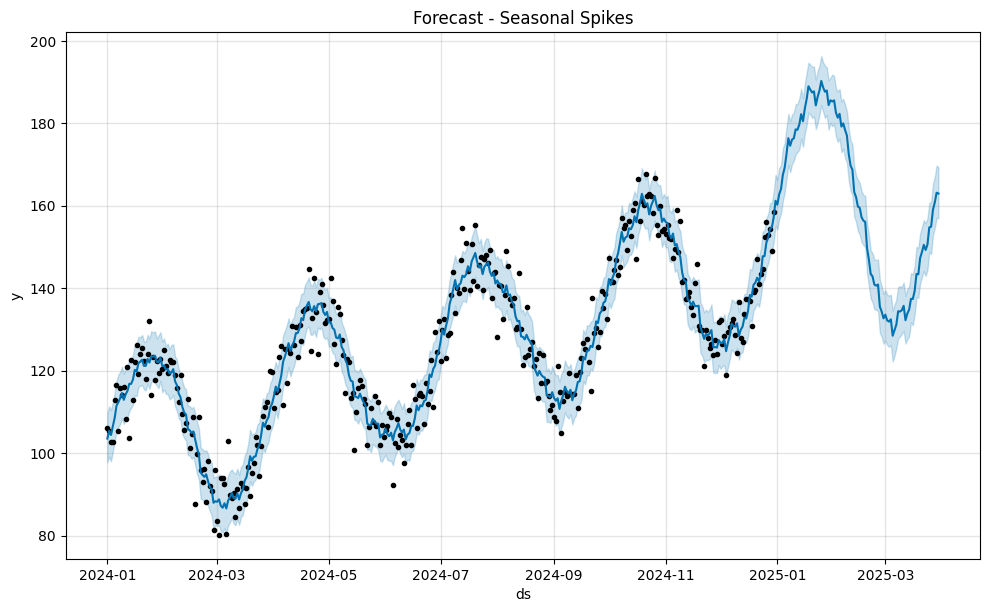

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from prophet import Prophet

# Generate synthetic dataset with seasonal spikes
start_date = datetime(2024, 1, 1)
num_days = 365
dates = [start_date + timedelta(days=i) for i in range(num_days)]

# Create a basic trend
base_sales = np.linspace(100, 150, num_days)
# Add a sine wave to simulate seasonal spikes (e.g., every 90 days)
seasonal_effect = 20 * np.sin(2 * np.pi * np.arange(num_days) / 90)
# Combine trend, seasonal effect, and random noise
sales = base_sales + seasonal_effect + np.random.normal(0, 5, num_days)

# Create DataFrame
df_spikes = pd.DataFrame({'ds': dates, 'y': sales})

# Plot the synthetic data
plt.figure(figsize=(10, 6))
plt.plot(df_spikes['ds'], df_spikes['y'])
plt.title("Synthetic Sales Data with Seasonal Spikes")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Apply Prophet
model_spikes = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
# Optionally add custom monthly seasonality
model_spikes.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_spikes.fit(df_spikes)

# Forecast for 90 future days
future_spikes = model_spikes.make_future_dataframe(periods=90)
forecast_spikes = model_spikes.predict(future_spikes)

# Plot the forecast
fig1 = model_spikes.plot(forecast_spikes)
plt.title("Forecast - Seasonal Spikes")
plt.show()

#Economic Downturn Scenario
This example simulates an economic downturn by reducing sales for a specified period

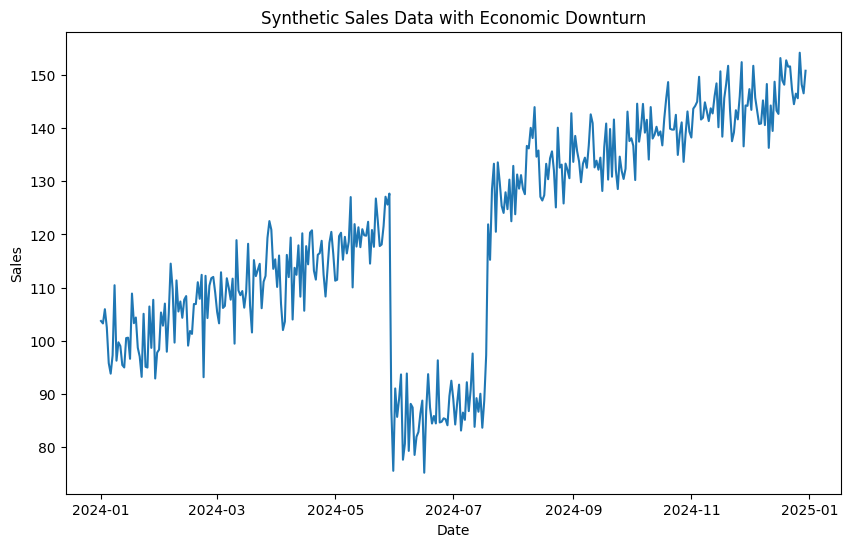

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/3bx46d9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/lzfty6j5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34156', 'data', 'file=/tmp/tmp9a4o68f2/3bx46d9z.json', 'init=/tmp/tmp9a4o68f2/lzfty6j5.json', 'output', 'file=/tmp/tmp9a4o68f2/prophet_model6b_if_t6/prophet_model-20250311181839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


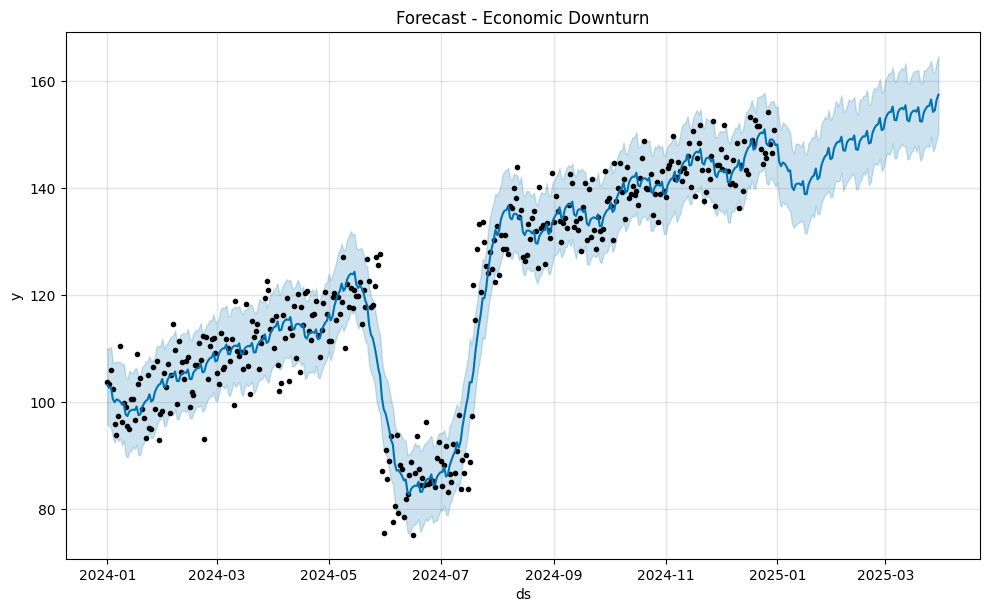

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from prophet import Prophet

# Generate synthetic dataset with an economic downturn
start_date = datetime(2024, 1, 1)
num_days = 365
dates = [start_date + timedelta(days=i) for i in range(num_days)]

# Create a basic trend
base_sales = np.linspace(100, 150, num_days)
# Copy base trend for downturn simulation
sales_downturn = base_sales.copy()

# Define downturn period (e.g., day 150 to day 200) and reduce sales by 30%
downturn_start, downturn_end = 150, 200
sales_downturn[downturn_start:downturn_end] *= 0.7

# Add random noise
sales_downturn = sales_downturn + np.random.normal(0, 5, num_days)

# Create DataFrame
df_downturn = pd.DataFrame({'ds': dates, 'y': sales_downturn})

# Plot the synthetic data
plt.figure(figsize=(10, 6))
plt.plot(df_downturn['ds'], df_downturn['y'])
plt.title("Synthetic Sales Data with Economic Downturn")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Apply Prophet
model_downturn = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
model_downturn.fit(df_downturn)

# Forecast for 90 future days
future_downturn = model_downturn.make_future_dataframe(periods=90)
forecast_downturn = model_downturn.predict(future_downturn)

# Plot the forecast
fig2 = model_downturn.plot(forecast_downturn)
plt.title("Forecast - Economic Downturn")
plt.show()

#Promotional Period Scenario
This example simulates a promotional period by temporarily boosting sales

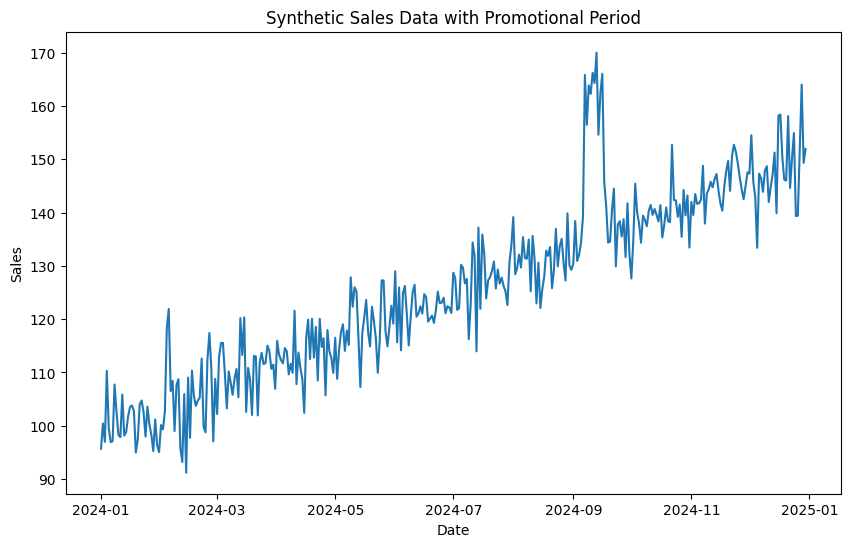

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/h2kku_bg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9a4o68f2/otamy1uu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83283', 'data', 'file=/tmp/tmp9a4o68f2/h2kku_bg.json', 'init=/tmp/tmp9a4o68f2/otamy1uu.json', 'output', 'file=/tmp/tmp9a4o68f2/prophet_modelpscyc4l1/prophet_model-20250311181909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


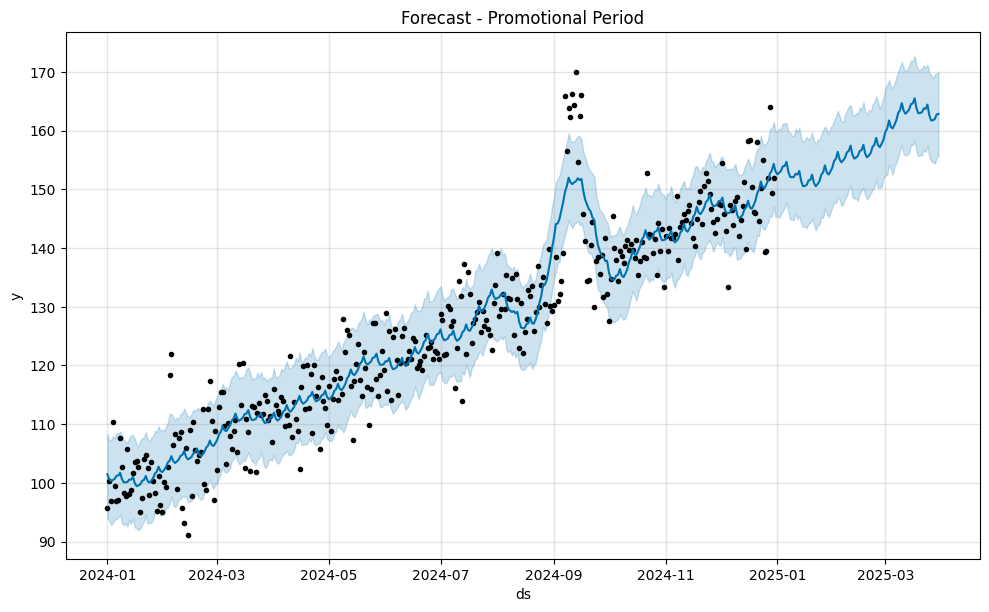

In [31]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from prophet import Prophet

# Generate synthetic dataset with a promotional period
start_date = datetime(2024, 1, 1)
num_days = 365
dates = [start_date + timedelta(days=i) for i in range(num_days)]

# Create a basic trend
base_sales = np.linspace(100, 150, num_days)
# Copy base trend for promotional simulation
sales_promo = base_sales.copy()

# Define promotional period (e.g., day 250 to day 260) and add a boost of 30 units
promo_start, promo_end = 250, 260
sales_promo[promo_start:promo_end] += 30

# Add random noise
sales_promo = sales_promo + np.random.normal(0, 5, num_days)

# Create DataFrame
df_promo = pd.DataFrame({'ds': dates, 'y': sales_promo})

# Plot the synthetic data
plt.figure(figsize=(10, 6))
plt.plot(df_promo['ds'], df_promo['y'])
plt.title("Synthetic Sales Data with Promotional Period")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Apply Prophet
model_promo = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
model_promo.fit(df_promo)

# Forecast for 90 future days
future_promo = model_promo.make_future_dataframe(periods=90)
forecast_promo = model_promo.predict(future_promo)

# Plot the forecast
fig3 = model_promo.plot(forecast_promo)
plt.title("Forecast - Promotional Period")
plt.show()